In [176]:
import numpy as np
import pandas as pd

mp = 0.93827                                                           #proton mass
pz = 158.0                                                             #beam momentum
root_s = (2 * mp * (mp + (mp ** 2 + pz ** 2) ** 0.5)) ** 0.5           #sqrt(s)
norm = 3.141593 * root_s / 2                                           #normalization in new coordinats

In [222]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import matplotlib.patches

def plot_heat_map(res, act_bins, bins, title, lims=None):

    cmap = matplotlib.colormaps['plasma']

    if lims is not None:
        normalize = Normalize(vmin=lims[0], vmax=lims[1])
        rgba_values = cmap(normalize(res))

    else:
        normalize = Normalize(vmin=np.min(res), vmax=np.max(res))
        rgba_values = cmap(normalize(res))
    
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111)

    for i, bin in enumerate(act_bins):

        x = bins[bin][0] - bins[bin][2]
        y = bins[bin][1] - bins[bin][3]
        w = 2 * bins[bin][2]
        h = 2 * bins[bin][3]

        rect = matplotlib.patches.Rectangle((x, y), w, h, color=rgba_values[i])
        ax.add_patch(rect)

    ax.set_xlim(-0.05, 0.91)
    ax.set_ylim(0, 2.3)

    #ax.text(0.55, 2, '$\chi^2_{mean}=$' + f'${np.mean(res):.5}$', fontdict={'size': 24})

    fig.colorbar(cm.ScalarMappable(norm=normalize, cmap=cmap), ax=ax)
    ax.set_title(title, fontdict={'size': 20})
    ax.set_ylabel(f'$p_T$', fontdict={'size': 20})
    ax.set_xlabel('$x_F$', fontdict={'size': 20})

    plt.show()

In [178]:
def xsect_calc(data, sigma, n_events, bins):

    xsect = []
    err = []

    for bin in bins:

        xF = bin[0]
        pT = bin[1]

        dxF = bin[2]
        dpT = bin[3]

        mask_for_bin = (data['xF'] > xF - dxF / 2) * \
            (data['xF'] < xF + dxF / 2) * \
            (data['pT'] > pT - dpT / 2) * \
            (data['pT'] < pT + dpT / 2)

        dn = np.sum(mask_for_bin)

        dp3 = dxF * 2 * pT * dpT

        E = data[mask_for_bin]['E']

        xsect.append(E.mean() * (sigma / n_events) * (dn / dp3) / norm)
        err.append(E.std() * (sigma / n_events) * (dn / dp3) / norm)

    xsect = np.where(np.isnan(xsect), 0, xsect)
    err = np.where(np.isnan(err), 0, 0)

    return xsect, err

In [179]:
def chi_square(y_hat, y, y_hat_err, y_err):

    return (y_hat - y) ** 2 / (y_hat_err ** 2 + y_err ** 2)

def chi_square_fair(y_hat, y, y_hat_err, y_err):

    fairness = y_err ** 2 / y ** 2
    chi_square = (y_hat - y) ** 2 / (y_hat_err ** 2 + y_err ** 2)

    return chi_square * fairness

In [180]:
def per_bin_metric_calc(xsect, err, bins, ref, metric):

    active_bins = []
    res = []

    for num, bin in enumerate(bins):

        mask = (ref['xF'] == bin[0]) * (ref['pT'] == bin[1])

        if np.sum(mask) != 0:

            active_bins.append(num)
            
            y = ref['xsect'][mask].values[0]
            y_hat = xsect[num]

            y_err = ref['error'][mask].values[0]
            y_hat_err = err[num]

            res.append(metric(y, y_hat,
                              y_err, y_hat_err))
            
    return res, active_bins

In [181]:
def get_score(n_events, data, sigma, ref, bins, metric):

    xsect, err = xsect_calc(data, sigma, n_events, bins)
    res, active_bins = per_bin_metric_calc(xsect, err, bins, ref, metric)
    
    return res, active_bins

In [182]:
bins_file = open('../exp_data/na49/binning.bin', 'r')

In [183]:
bins = []

for num, line in enumerate(bins_file.readlines()):

    if num % 2 == 0:
        
        a = line.split('|')

        for bin in a:

            bin = bin.replace('(', '').replace(')', '').replace(' ', '')
            bins.append(list(map(float, bin.split(','))))

bins = np.array(bins)

bins_file.close()

In [184]:
ids = [211]

refs = {}

for id in ids:
    
    refs[id] = pd.read_csv(f'../exp_data/na49/{id}.csv')

In [185]:
data = pd.read_csv('data/data.csv')
sigma = float(open('data/sigma.txt', 'r').readline())

In [186]:
samples = [get_score(int(1e6), data[data['id'] == 211].sample(frac=0.1), sigma, refs[211], bins, chi_square)[0] for _ in range(10)]

In [209]:
score7, active_bins = get_score(int(1e7), data[data['id'] == 211], sigma, refs[211], bins, chi_square)

In [210]:
score7 = np.array(score7)

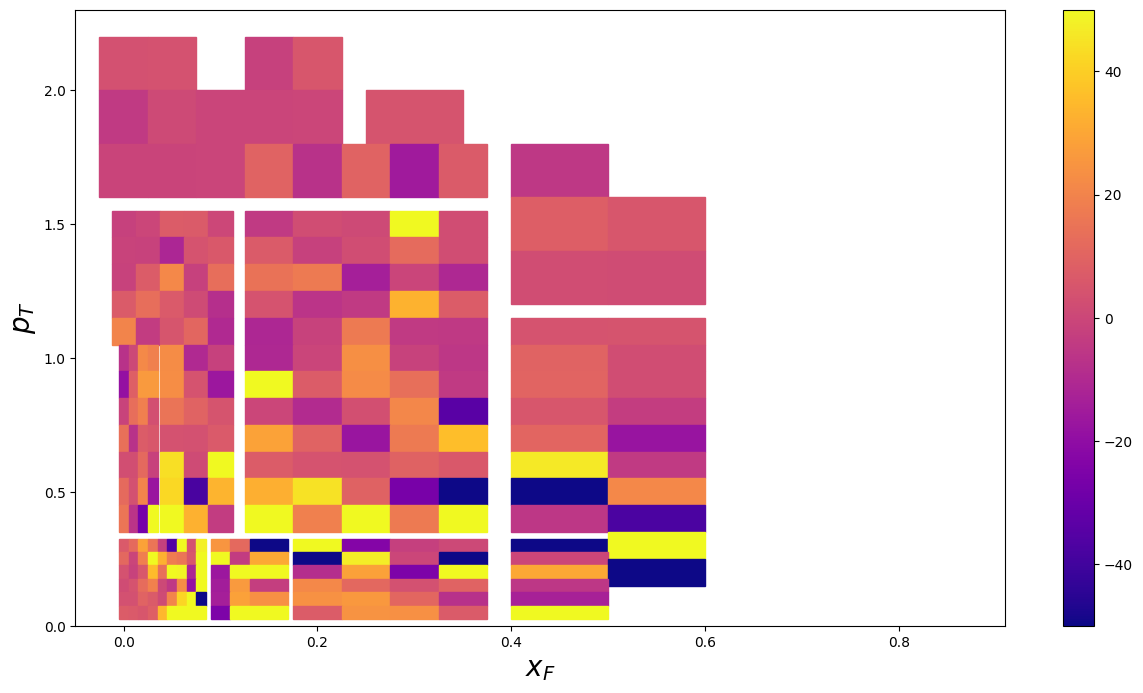

In [223]:
plot_heat_map(np.mean(np.array(samples) - score7, axis=0), active_bins, bins, '', lims=[-50, 50])

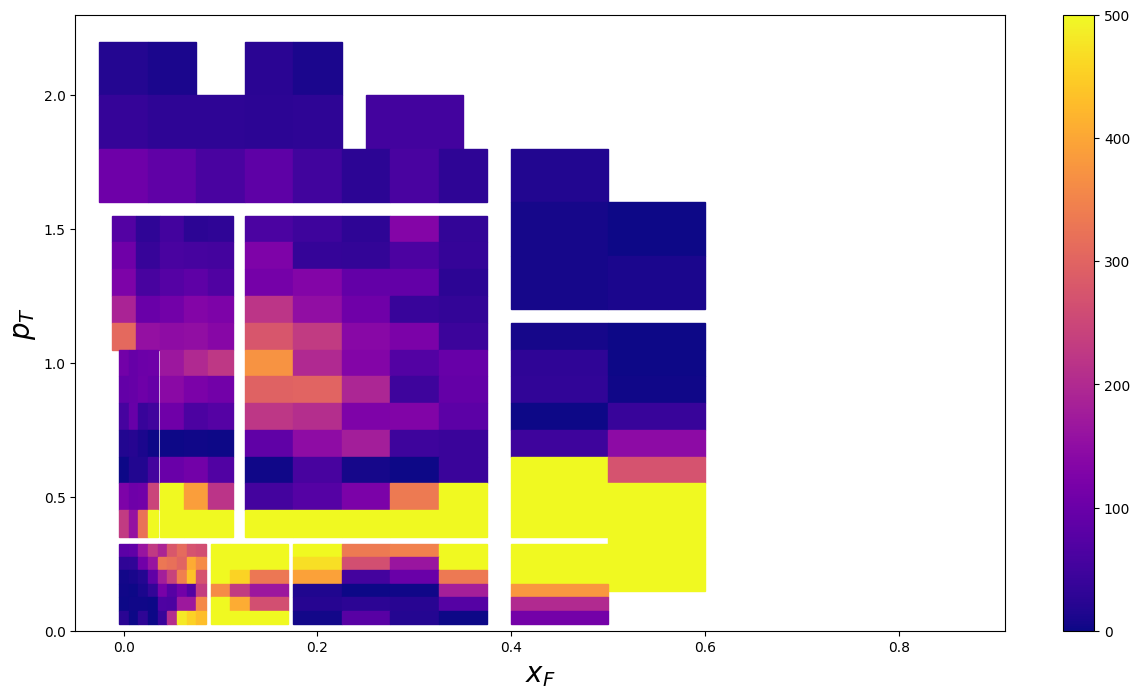

In [224]:
plot_heat_map(score7, active_bins, bins, '', lims=[0, 500])

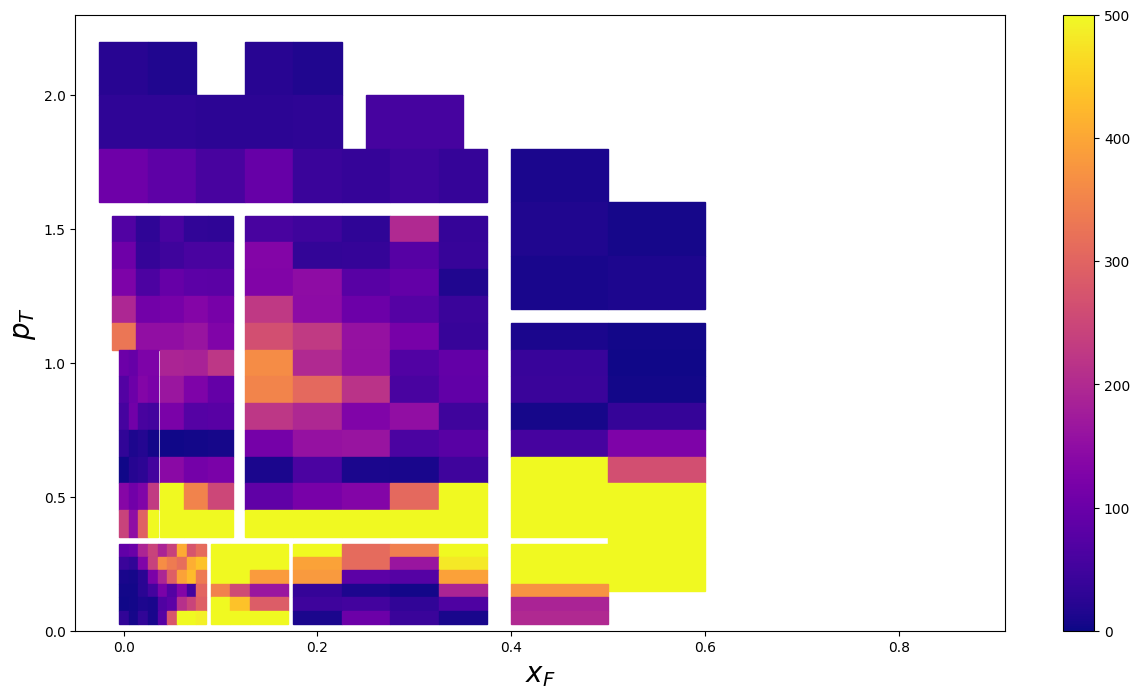

In [225]:
plot_heat_map(np.mean(np.array(samples), axis=0), active_bins, bins, '', lims=[0, 500])